In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor
from itertools import combinations



In [2]:
df = pd.read_csv('C:/Users/Multiplexon/Desktop/data/d6/total 06.csv', sep=',')
df.head()


,Transaction Hash_len,Original_len,signature_len,From_len,To_len,sender_len,paymaster_len,Txn Fee,Gas Used,logIndex,actualGasCost,actualGasUsed,nonce,success,Blockno,DateTime_ts
0,32,1412,4,20,20,20,20,0.004663,360963,77,5.580000e+15,432020,6.0,1,18909051,1704069120
1,32,900,4,20,20,20,20,0.001098,97441,80,1.250000e+15,110855,33.0,1,18909074,1704069360
2,32,1636,4,20,20,20,20,0.003643,306649,60,4.450000e+15,374766,7.0,1,18909211,1704071040
3,32,1636,4,20,20,20,20,0.003438,281030,55,4.270000e+15,349159,8.0,1,18909215,1704071100
4,32,1636,4,20,20,20,20,0.001824,142131,155,2.110000e+15,164548,9.0,1,18909225,1704071220


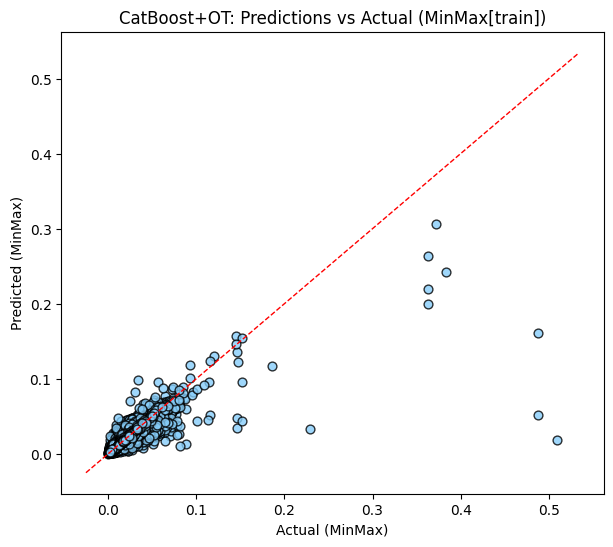

In [ ]:
# ================== SCATTER (MinMax[train]) ==================
import matplotlib.pyplot as plt

# y_true/y_pred trên thang MinMax (đã có từ phần đánh giá cuối)
y_true_mm = y_test_mm
y_pred_mm = y_pred_test_mm

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(y_true_mm, y_pred_mm, s=40, alpha=0.8, color="lightskyblue", edgecolors="k")

# Vẽ đường y = x theo giới hạn hiện tại của trục
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
lo, hi = min(x0, y0), max(x1, y1)
ax.plot([lo, hi], [lo, hi], "--", linewidth=1,color="red")

ax.set_title("CatBoost+OT: Predictions vs Actual (MinMax[train])")
ax.set_xlabel("Actual (MinMax)")
ax.set_ylabel("Predicted (MinMax)")
plt.show()

In [22]:
#optimize parameters OT-catboost with RandomizedSearchCV
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score, make_scorer
from catboost import CatBoostRegressor
from scipy.stats import wasserstein_distance

SEED = 42
np.random.seed(SEED)

# ================== HELPER FUNCTIONS ==================
def combine_last_k_leaf_ids(leaf_mat, k_last=1):
    L = np.asarray(leaf_mat)
    if L.ndim == 1:
        return L.astype(np.int64)
    k = max(1, min(int(k_last), L.shape[1]))
    sub = L[:, -k:]
    base = int(sub.max()) + 1
    powers = (base ** np.arange(sub.shape[1], dtype=np.int64))
    return (sub.astype(np.int64) * powers).sum(axis=1)

def real_wasserstein_distance(residuals_leaf, residuals_global, n_samples=1000):
    if len(residuals_leaf) < 10:
        return 0.0
    rng = np.random.default_rng(SEED)
    if len(residuals_leaf) > n_samples:
        residuals_leaf = rng.choice(residuals_leaf, n_samples, replace=False)
    if len(residuals_global) > n_samples:
        residuals_global = rng.choice(residuals_global, n_samples, replace=False)
    return wasserstein_distance(residuals_leaf, residuals_global)

def real_ot_penalty(residuals, leaf_assignments, lam=0.1):
    unique_leaves = np.unique(leaf_assignments)
    penalties = np.zeros(len(unique_leaves), dtype=np.float64)
    global_residuals = residuals
    for i, leaf_id in enumerate(unique_leaves):
        leaf_mask = (leaf_assignments == leaf_id)
        leaf_residuals = residuals[leaf_mask]
        if len(leaf_residuals) < 8:
            continue
        w_dist = real_wasserstein_distance(leaf_residuals, global_residuals)
        penalties[i] = lam * w_dist
    return penalties

# ================== CUSTOM ESTIMATOR ==================
class OTCatBoostRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, lam=0.05, k_last=2, stage=400, rounds=5,
                 depth=8, learning_rate=0.05, l2_leaf_reg=5):
        self.lam = lam
        self.k_last = k_last
        self.stage = stage
        self.rounds = rounds
        self.depth = depth
        self.learning_rate = learning_rate
        self.l2_leaf_reg = l2_leaf_reg
        self.model_ = None

    def fit(self, X, y):
        w = np.ones(len(y), dtype=np.float64)
        model = None
        for r in range(1, self.rounds + 1):
            iters = (model.tree_count_ if model else 0) + self.stage
            booster = CatBoostRegressor(
                iterations=iters,
                depth=self.depth,
                learning_rate=self.learning_rate,
                l2_leaf_reg=self.l2_leaf_reg,
                loss_function="RMSE",
                random_seed=SEED,
                verbose=False,
                allow_writing_files=False,
                thread_count=-1
            )
            booster.fit(X, y, sample_weight=w, init_model=None if model is None else model)
            model = booster
            res = y - model.predict(X)
            leaf_idx = model.calc_leaf_indexes(X,
                ntree_start=max(model.tree_count_ - self.k_last, 0),
                ntree_end=model.tree_count_)
            leaf_idx = np.asarray(leaf_idx)
            if leaf_idx.ndim == 1:
                leaf_idx = leaf_idx.reshape(-1, 1)
            codes = combine_last_k_leaf_ids(leaf_idx, self.k_last)
            _, inv = np.unique(codes, return_inverse=True)
            pen = real_ot_penalty(res, inv, self.lam)
            w *= np.exp(-pen[inv])
            w /= (w.mean() + 1e-12)
            w = np.clip(w, 0.05, 10.0)
        self.model_ = model
        return self

    def predict(self, X):
        return self.model_.predict(X)

# ================== LOAD AND PREPROCESS ==================
PATH = "C:/Users/Multiplexon/Desktop/data/d6/total 06.csv"
FEATS = ['Original_len','Txn Fee','logIndex','actualGasCost','Blockno','DateTime_ts','nonce']
TARGET = 'Gas Used'

df = pd.read_csv(PATH, usecols=lambda c: c in FEATS + [TARGET])
for c in FEATS + [TARGET]:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.loc[df[TARGET] < -1, TARGET] = np.nan
df.dropna(subset=[TARGET], inplace=True)

X = df[FEATS].to_numpy(dtype=np.float64)
y = df[TARGET].to_numpy(dtype=np.float64)

X_train, X_val, y_train_raw, y_val_raw = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Impute + scale
imp = SimpleImputer(strategy="median").fit(X_train)
X_train_imp = imp.transform(X_train)
X_val_imp = imp.transform(X_val)

scaler = MinMaxScaler().fit(X_train_imp)
X_train_scaled = scaler.transform(X_train_imp).astype(np.float32)
X_val_scaled = scaler.transform(X_val_imp).astype(np.float32)

# Log transform
y_train_log = np.log1p(y_train_raw.astype(np.float64))
y_val_log = np.log1p(y_val_raw.astype(np.float64))

# ================== RANDOM SEARCH CV ==================
param_dist = {
    'lam': [0.03, 0.05, 0.07],
    'k_last': [2, 3, 4],
    'stage': [400, 600, 800],
    'rounds': [3, 5, 7]
}

search = RandomizedSearchCV(
    estimator=OTCatBoostRegressor(),
    param_distributions=param_dist,
    scoring=make_scorer(r2_score),
    n_iter=10,
    cv=5,
    verbose=2,
    random_state=SEED,
    n_jobs=-1
)

search.fit(X_train_scaled, y_train_log)
best_model = search.best_estimator_

# ================== EVALUATION ==================
y_pred_log = best_model.predict(X_val_scaled)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_val_log)
r2 = r2_score(y_true, y_pred)

print("\n✅ BEST PARAMETERS:", search.best_params_)
print(f"✅ Final R² on held-out set: {r2:.6f}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits

✅ BEST PARAMETERS: {'stage': 600, 'rounds': 5, 'lam': 0.07, 'k_last': 2}
✅ Final R² on held-out set: 0.855267


In [23]:
#WASSSENTERIN 1/ optimized
# ================================================================
# 🚀 REAL OT-CATBOOST (WASSERSTEIN-1) FOR ENTRYPOINT ADDRESS v06
# ================================================================
import numpy as np, pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
from scipy.stats import wasserstein_distance

# ================== CONFIGURATION ==================
SEED = 42
np.random.seed(SEED)

PATH = "C:/Users/Multiplexon/Desktop/data/d6/total 06.csv"
FEATS = ['Original_len', 'Txn Fee', 'logIndex', 'actualGasCost', 'Blockno', 'DateTime_ts', 'nonce']
TARGET = 'Gas Used'

# OT-CatBoost hyperparameters
ROUNDS      = 5
STAGE       = 600
K_LAST      = 2
LAM         = 0.07


# ===================================================
# 1️⃣ DATA LOADING & PREPROCESSING
# ===================================================
use_cols = FEATS + [TARGET]
df = pd.read_csv(PATH, usecols=lambda c: c in use_cols)

for c in use_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.loc[df[TARGET] < -1, TARGET] = np.nan
df = df.dropna(subset=[TARGET]).reset_index(drop=True)

X = df[FEATS].to_numpy(dtype=np.float64)
y_raw = df[TARGET].to_numpy(dtype=np.float64)

# ===================================================
# 2️⃣ HELPER FUNCTIONS
# ===================================================
def combine_last_k_leaf_ids(leaf_mat, k_last=1):
    """Combine last k leaf indexes into unique group IDs."""
    L = np.asarray(leaf_mat)
    if L.ndim == 1:
        return L.astype(np.int64)
    k = max(1, min(int(k_last), L.shape[1]))
    sub = L[:, -k:]
    base = int(sub.max()) + 1
    powers = (base ** np.arange(sub.shape[1], dtype=np.int64))
    return (sub.astype(np.int64) * powers).sum(axis=1)

def real_wasserstein_distance(residuals_leaf, residuals_global, n_samples=1000):
    """Compute true Wasserstein-1 (Earth Mover's) distance."""
    if len(residuals_leaf) < 10:
        return 0.0
    rng = np.random.default_rng(SEED)
    if len(residuals_leaf) > n_samples:
        residuals_leaf = rng.choice(residuals_leaf, n_samples, replace=False)
    if len(residuals_global) > n_samples:
        residuals_global = rng.choice(residuals_global, n_samples, replace=False)
    return wasserstein_distance(residuals_leaf, residuals_global)

def real_ot_penalty(residuals, leaf_assignments, lam=0.1):
    """
    Compute Wasserstein-1 penalties per leaf group.
    Penalize groups whose residual distributions deviate 
    significantly from the global residual distribution.
    """
    unique_leaves = np.unique(leaf_assignments)
    n_leaves = len(unique_leaves)
    penalties = np.zeros(n_leaves, dtype=np.float64)
    global_residuals = residuals

    for i, leaf_id in enumerate(unique_leaves):
        leaf_mask = (leaf_assignments == leaf_id)
        leaf_residuals = residuals[leaf_mask]
        if len(leaf_residuals) < 8:
            penalties[i] = 0.0
            continue
        w_dist = real_wasserstein_distance(leaf_residuals, global_residuals)
        penalties[i] = lam * w_dist
    return penalties

# ===================================================
# 3️⃣ 10-FOLD CROSS VALIDATION
# ===================================================
kf = KFold(n_splits=10, shuffle=True, random_state=SEED)
metrics_all = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    print(f"\n===== Fold {fold} =====")

    # Split
    X_train, X_test = X[train_idx], X[test_idx]
    y_train_raw, y_test_raw = y_raw[train_idx], y_raw[test_idx]

    # Target scaling
    y_mm_scaler = MinMaxScaler()
    y_train_mm = y_mm_scaler.fit_transform(y_train_raw.reshape(-1, 1)).ravel()
    y_test_mm  = y_mm_scaler.transform(y_test_raw.reshape(-1, 1)).ravel()

    # Feature impute + scale
    X_train[~np.isfinite(X_train)] = np.nan
    X_test[~np.isfinite(X_test)]   = np.nan
    imp = SimpleImputer(strategy="median").fit(X_train)
    X_train_imp = imp.transform(X_train)
    X_test_imp  = imp.transform(X_test)
    scaler = MinMaxScaler().fit(X_train_imp)
    X_train_s = scaler.transform(X_train_imp).astype(np.float32)
    X_test_s  = scaler.transform(X_test_imp).astype(np.float32)

    # Target transform (log1p)
    y_train = np.log1p(y_train_raw.astype(np.float64))
    y_test  = np.log1p(y_test_raw.astype(np.float64))

    # ===================================================
    # 4️⃣ TRAINING LOOP WITH REAL OT REWEIGHTING
    # ===================================================
    w = np.ones(len(y_train), dtype=np.float64)
    model = None

    for r in range(1, ROUNDS + 1):
        iters = (model.tree_count_ if model is not None else 0) + STAGE
        booster = CatBoostRegressor(
            iterations=iters, depth=8, learning_rate=0.05, l2_leaf_reg=5,
            loss_function="RMSE", random_seed=SEED, verbose=False,
            allow_writing_files=False, thread_count=-1
        )
        booster.fit(
            X_train_s, y_train, sample_weight=w,
            init_model=None if model is None else model
        )
        model = booster

        # Compute residuals
        res = y_train - model.predict(X_train_s)

        # Group residuals by leaf path
        leaf_idx = model.calc_leaf_indexes(
            X_train_s,
            ntree_start=max(model.tree_count_ - K_LAST, 0),
            ntree_end=model.tree_count_,
            thread_count=-1
        )
        leaf_idx = np.asarray(leaf_idx)
        if leaf_idx.ndim == 1:
            leaf_idx = leaf_idx.reshape(-1, 1)
        codes = combine_last_k_leaf_ids(leaf_idx, k_last=K_LAST)
        _, inv = np.unique(codes, return_inverse=True)

        # Apply OT penalty (W1 distance)
        pen = real_ot_penalty(residuals=res, leaf_assignments=inv, lam=LAM)

        # Update weights
        w *= np.exp(-pen[inv])
        w /= (w.mean() + 1e-12)
        w = np.clip(w, 1e-3, 50.0)

    # ===================================================
    # 5️⃣ EVALUATION ON TEST SET
    # ===================================================
    y_pred_raw = np.expm1(model.predict(X_test_s))
    y_pred_mm  = y_mm_scaler.transform(y_pred_raw.reshape(-1, 1)).ravel()

    mse  = mean_squared_error(y_test_mm, y_pred_mm)
    rmse = mean_squared_error(y_test_mm, y_pred_mm, squared=False)
    mae  = mean_absolute_error(y_test_mm, y_pred_mm)
    r2   = r2_score(y_test_mm, y_pred_mm)

    print(f"Fold {fold} [MinMax]: RMSE={rmse:.6f}, MSE={mse:.6f}, MAE={mae:.6f}, R2={r2:.6f}")
    metrics_all.append([rmse, mse, mae, r2])

# ===================================================
# 6️⃣ SUMMARY OF RESULTS
# ===================================================
metrics_all = np.array(metrics_all)
print("\n=== 10-FOLD AVERAGE (MinMax) ===")
print(f"RMSE: {metrics_all[:,0].mean():.6f}")
print(f"MSE : {metrics_all[:,1].mean():.6f}")
print(f"MAE : {metrics_all[:,2].mean():.6f}")
print(f"R²  : {metrics_all[:,3].mean():.6f}")



===== Fold 1 =====
Fold 1 [MinMax]: RMSE=0.004744, MSE=0.000023, MAE=0.002132, R2=0.848444

===== Fold 2 =====
Fold 2 [MinMax]: RMSE=0.004318, MSE=0.000019, MAE=0.002137, R2=0.867466

===== Fold 3 =====
Fold 3 [MinMax]: RMSE=0.009863, MSE=0.000097, MAE=0.003276, R2=0.747955

===== Fold 4 =====
Fold 4 [MinMax]: RMSE=0.005348, MSE=0.000029, MAE=0.002165, R2=0.816161

===== Fold 5 =====
Fold 5 [MinMax]: RMSE=0.005505, MSE=0.000030, MAE=0.002162, R2=0.808559

===== Fold 6 =====
Fold 6 [MinMax]: RMSE=0.005129, MSE=0.000026, MAE=0.002167, R2=0.823902

===== Fold 7 =====
Fold 7 [MinMax]: RMSE=0.003978, MSE=0.000016, MAE=0.002129, R2=0.885429

===== Fold 8 =====
Fold 8 [MinMax]: RMSE=0.005337, MSE=0.000028, MAE=0.002166, R2=0.819056

===== Fold 9 =====
Fold 9 [MinMax]: RMSE=0.005312, MSE=0.000028, MAE=0.002188, R2=0.816413

===== Fold 10 =====
Fold 10 [MinMax]: RMSE=0.005365, MSE=0.000029, MAE=0.002149, R2=0.824885

=== 10-FOLD AVERAGE (MinMax) ===
RMSE: 0.005490
MSE : 0.000032
MAE : 0.002267

In [31]:
# ================================================================
# 🚀 REAL OT-CATBOOST (WASSERSTEIN-1) FOR ENTRYPOINT ADDRESS v06 - FIXED
# ================================================================
import numpy as np, pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
from scipy.stats import wasserstein_distance

# ================== CONFIGURATION ==================
SEED = 42
np.random.seed(SEED)

PATH = "C:/Users/Multiplexon/Desktop/data/d6/total 06.csv"
FEATS = ['Original_len', 'Txn Fee', 'logIndex', 'actualGasCost', 'Blockno', 'DateTime_ts', 'nonce']
TARGET = 'Gas Used'

# OT-CatBoost hyperparameters
ROUNDS      = 5
STAGE       = 600
K_LAST      = 2
LAM         = 0.07

# ================== EPOCHS CONFIG ==================
EPOCHS = 20

# ===================================================
# 1️⃣ DATA LOADING & PREPROCESSING
# ===================================================
use_cols = FEATS + [TARGET]
df = pd.read_csv(PATH, usecols=lambda c: c in use_cols)

for c in use_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.loc[df[TARGET] < -1, TARGET] = np.nan
df = df.dropna(subset=[TARGET]).reset_index(drop=True)

X = df[FEATS].to_numpy(dtype=np.float64)
y_raw = df[TARGET].to_numpy(dtype=np.float64)

# FIX: Tạo train/test split để có thể shuffle mỗi epoch
X_full, y_full = X, y_raw

# ===================================================
# 2️⃣ HELPER FUNCTIONS
# ===================================================
def combine_last_k_leaf_ids(leaf_mat, k_last=1):
    """Combine last k leaf indexes into unique group IDs."""
    L = np.asarray(leaf_mat)
    if L.ndim == 1:
        return L.astype(np.int64)
    k = max(1, min(int(k_last), L.shape[1]))
    sub = L[:, -k:]
    base = int(sub.max()) + 1
    powers = (base ** np.arange(sub.shape[1], dtype=np.int64))
    return (sub.astype(np.int64) * powers).sum(axis=1)

def real_wasserstein_distance(residuals_leaf, residuals_global, n_samples=1000):
    """Compute true Wasserstein-1 (Earth Mover's) distance."""
    if len(residuals_leaf) < 10:
        return 0.0
    rng = np.random.default_rng(SEED)
    if len(residuals_leaf) > n_samples:
        residuals_leaf = rng.choice(residuals_leaf, n_samples, replace=False)
    if len(residuals_global) > n_samples:
        residuals_global = rng.choice(residuals_global, n_samples, replace=False)
    return wasserstein_distance(residuals_leaf, residuals_global)

def real_ot_penalty(residuals, leaf_assignments, lam=0.1):
    """
    Compute Wasserstein-1 penalties per leaf group.
    Penalize groups whose residual distributions deviate 
    significantly from the global residual distribution.
    """
    unique_leaves = np.unique(leaf_assignments)
    n_leaves = len(unique_leaves)
    penalties = np.zeros(n_leaves, dtype=np.float64)
    global_residuals = residuals

    for i, leaf_id in enumerate(unique_leaves):
        leaf_mask = (leaf_assignments == leaf_id)
        leaf_residuals = residuals[leaf_mask]
        if len(leaf_residuals) < 8:
            penalties[i] = 0.0
            continue
        w_dist = real_wasserstein_distance(leaf_residuals, global_residuals)
        penalties[i] = lam * w_dist
    return penalties

# ===================================================
# 3️⃣ 20 EPOCHS × 10-FOLD CROSS VALIDATION - FIXED
# ===================================================
rd = np.zeros((EPOCHS, 4), dtype=np.float64)   # [RMSE, MSE, MAE, R2]

for epoch in range(EPOCHS):
    # FIX: Tạo permutation cho mỗi epoch để có sự biến đổi
    idx = np.random.permutation(len(X_full))
    X_ep = X_full[idx]
    y_ep = y_full[idx]
    
    kf = KFold(n_splits=10, shuffle=True, random_state=SEED)
    metrics_all = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X_ep), 1):
        # Split từ dữ liệu đã permuted
        X_train, X_test = X_ep[train_idx], X_ep[test_idx]
        y_train_raw, y_test_raw = y_ep[train_idx], y_ep[test_idx]

        # Target scaling
        y_mm_scaler = MinMaxScaler()
        y_train_mm = y_mm_scaler.fit_transform(y_train_raw.reshape(-1, 1)).ravel()
        y_test_mm  = y_mm_scaler.transform(y_test_raw.reshape(-1, 1)).ravel()

        # Feature impute + scale
        X_train[~np.isfinite(X_train)] = np.nan
        X_test[~np.isfinite(X_test)]   = np.nan
        imp = SimpleImputer(strategy="median").fit(X_train)
        X_train_imp = imp.transform(X_train)
        X_test_imp  = imp.transform(X_test)
        scaler = MinMaxScaler().fit(X_train_imp)
        X_train_s = scaler.transform(X_train_imp).astype(np.float32)
        X_test_s  = scaler.transform(X_test_imp).astype(np.float32)

        # Target transform (log1p)
        y_train = np.log1p(y_train_raw.astype(np.float64))
        y_test  = np.log1p(y_test_raw.astype(np.float64))

        # ===================================================
        # 4️⃣ TRAINING LOOP WITH REAL OT REWEIGHTING
        # ===================================================
        w = np.ones(len(y_train), dtype=np.float64)
        model = None

        for r in range(1, ROUNDS + 1):
            iters = (model.tree_count_ if model is not None else 0) + STAGE
            # FIX: Thêm randomness cho CatBoost mỗi fold
            booster = CatBoostRegressor(
                iterations=iters, depth=8, learning_rate=0.05, l2_leaf_reg=5,
                loss_function="RMSE", 
                random_seed=SEED,  
                verbose=False,
                allow_writing_files=False, 
                thread_count=-1
            )
            booster.fit(
                X_train_s, y_train, sample_weight=w,
                init_model=None if model is None else model
            )
            model = booster

            # Compute residuals
            res = y_train - model.predict(X_train_s)

            # Group residuals by leaf path
            leaf_idx = model.calc_leaf_indexes(
                X_train_s,
                ntree_start=max(model.tree_count_ - K_LAST, 0),
                ntree_end=model.tree_count_,
                thread_count=-1
            )
            leaf_idx = np.asarray(leaf_idx)
            if leaf_idx.ndim == 1:
                leaf_idx = leaf_idx.reshape(-1, 1)
            codes = combine_last_k_leaf_ids(leaf_idx, k_last=K_LAST)
            _, inv = np.unique(codes, return_inverse=True)

            # Apply OT penalty (W1 distance)
            pen = real_ot_penalty(residuals=res, leaf_assignments=inv, lam=LAM)

            # Update weights
            w *= np.exp(-pen[inv])
            w /= (w.mean() + 1e-12)
            w = np.clip(w, 1e-3, 50.0)

        # ===================================================
        # 5️⃣ EVALUATION ON TEST SET
        # ===================================================
        y_pred_raw = np.expm1(model.predict(X_test_s))
        y_pred_mm  = y_mm_scaler.transform(y_pred_raw.reshape(-1, 1)).ravel()

        mse  = mean_squared_error(y_test_mm, y_pred_mm)
        rmse = mean_squared_error(y_test_mm, y_pred_mm, squared=False)
        mae  = mean_absolute_error(y_test_mm, y_pred_mm)
        r2   = r2_score(y_test_mm, y_pred_mm)

        metrics_all.append([rmse, mse, mae, r2])
        print(f"Epoch {epoch+1}, Fold {fold}: RMSE: {rmse:.6f}, R2: {r2:.6f}")

    # Store epoch results
    rd[epoch, :] = np.mean(metrics_all, axis=0)
    print(f"Epoch {epoch + 1} Average - RMSE: {rd[epoch, 0]:.6f}, MSE: {rd[epoch, 1]:.6f}, MAE: {rd[epoch, 2]:.6f}, R2: {rd[epoch, 3]:.6f}")

# ================== OUTPUT ==================
np.set_printoptions(precision=8, suppress=False)
print("array(" + np.array2string(rd, separator=', ', prefix='array(') + ")")

final_mean = rd.mean(axis=0)
final_std  = rd.std(axis=0, ddof=1)
print("\nMean over 20 runs (RMSE, MSE, MAE, R2):", final_mean)
print("Std  over 20 runs (RMSE, MSE, MAE, R2):", final_std)



Epoch 1, Fold 1: RMSE: 0.004996, R2: 0.835103
Epoch 1, Fold 2: RMSE: 0.005055, R2: 0.823394
Epoch 1, Fold 3: RMSE: 0.004530, R2: 0.862155
Epoch 1, Fold 4: RMSE: 0.008898, R2: 0.791777
Epoch 1, Fold 5: RMSE: 0.005256, R2: 0.825206
Epoch 1, Fold 6: RMSE: 0.005319, R2: 0.827685
Epoch 1, Fold 7: RMSE: 0.005637, R2: 0.798816
Epoch 1, Fold 8: RMSE: 0.005306, R2: 0.811154
Epoch 1, Fold 9: RMSE: 0.004819, R2: 0.838474
Epoch 1, Fold 10: RMSE: 0.005361, R2: 0.809223
Epoch 1 Average - RMSE: 0.005518, MSE: 0.000032, MAE: 0.002264, R2: 0.822299
Epoch 2, Fold 1: RMSE: 0.005044, R2: 0.830349
Epoch 2, Fold 2: RMSE: 0.005129, R2: 0.825847
Epoch 2, Fold 3: RMSE: 0.005233, R2: 0.823560
Epoch 2, Fold 4: RMSE: 0.005027, R2: 0.836246
Epoch 2, Fold 5: RMSE: 0.008998, R2: 0.786773
Epoch 2, Fold 6: RMSE: 0.004963, R2: 0.829984
Epoch 2, Fold 7: RMSE: 0.006416, R2: 0.758358
Epoch 2, Fold 8: RMSE: 0.004274, R2: 0.868351
Epoch 2, Fold 9: RMSE: 0.005338, R2: 0.821236
Epoch 2, Fold 10: RMSE: 0.004303, R2: 0.872232
E

In [25]:
#optimize OT-Catboost, v07
#optimize parameters OT-catboost with RandomizedSearchCV
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score, make_scorer
from catboost import CatBoostRegressor
from scipy.stats import wasserstein_distance

SEED = 42
np.random.seed(SEED)

# ================== HELPER FUNCTIONS ==================
def combine_last_k_leaf_ids(leaf_mat, k_last=1):
    L = np.asarray(leaf_mat)
    if L.ndim == 1:
        return L.astype(np.int64)
    k = max(1, min(int(k_last), L.shape[1]))
    sub = L[:, -k:]
    base = int(sub.max()) + 1
    powers = (base ** np.arange(sub.shape[1], dtype=np.int64))
    return (sub.astype(np.int64) * powers).sum(axis=1)

def real_wasserstein_distance(residuals_leaf, residuals_global, n_samples=1000):
    if len(residuals_leaf) < 10:
        return 0.0
    rng = np.random.default_rng(SEED)
    if len(residuals_leaf) > n_samples:
        residuals_leaf = rng.choice(residuals_leaf, n_samples, replace=False)
    if len(residuals_global) > n_samples:
        residuals_global = rng.choice(residuals_global, n_samples, replace=False)
    return wasserstein_distance(residuals_leaf, residuals_global)

def real_ot_penalty(residuals, leaf_assignments, lam=0.1):
    unique_leaves = np.unique(leaf_assignments)
    penalties = np.zeros(len(unique_leaves), dtype=np.float64)
    global_residuals = residuals
    for i, leaf_id in enumerate(unique_leaves):
        leaf_mask = (leaf_assignments == leaf_id)
        leaf_residuals = residuals[leaf_mask]
        if len(leaf_residuals) < 8:
            continue
        w_dist = real_wasserstein_distance(leaf_residuals, global_residuals)
        penalties[i] = lam * w_dist
    return penalties

# ================== CUSTOM ESTIMATOR ==================
class OTCatBoostRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, lam=0.05, k_last=2, stage=400, rounds=5,
                 depth=8, learning_rate=0.05, l2_leaf_reg=5):
        self.lam = lam
        self.k_last = k_last
        self.stage = stage
        self.rounds = rounds
        self.depth = depth
        self.learning_rate = learning_rate
        self.l2_leaf_reg = l2_leaf_reg
        self.model_ = None

    def fit(self, X, y):
        w = np.ones(len(y), dtype=np.float64)
        model = None
        for r in range(1, self.rounds + 1):
            iters = (model.tree_count_ if model else 0) + self.stage
            booster = CatBoostRegressor(
                iterations=iters,
                depth=self.depth,
                learning_rate=self.learning_rate,
                l2_leaf_reg=self.l2_leaf_reg,
                loss_function="RMSE",
                random_seed=SEED,
                verbose=False,
                allow_writing_files=False,
                thread_count=-1
            )
            booster.fit(X, y, sample_weight=w, init_model=None if model is None else model)
            model = booster
            res = y - model.predict(X)
            leaf_idx = model.calc_leaf_indexes(X,
                ntree_start=max(model.tree_count_ - self.k_last, 0),
                ntree_end=model.tree_count_)
            leaf_idx = np.asarray(leaf_idx)
            if leaf_idx.ndim == 1:
                leaf_idx = leaf_idx.reshape(-1, 1)
            codes = combine_last_k_leaf_ids(leaf_idx, self.k_last)
            _, inv = np.unique(codes, return_inverse=True)
            pen = real_ot_penalty(res, inv, self.lam)
            w *= np.exp(-pen[inv])
            w /= (w.mean() + 1e-12)
            w = np.clip(w, 0.05, 10.0)
        self.model_ = model
        return self

    def predict(self, X):
        return self.model_.predict(X)

# ================== LOAD AND PREPROCESS ==================
PATH = "C:/Users/Multiplexon/Desktop/data/d7/total 7.csv"
FEATS = ['Original_len','Txn Fee','logIndex','actualGasCost','Blockno','DateTime_ts','nonce']
TARGET = 'Gas Used'

df = pd.read_csv(PATH, usecols=lambda c: c in FEATS + [TARGET])
for c in FEATS + [TARGET]:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.loc[df[TARGET] < -1, TARGET] = np.nan
df.dropna(subset=[TARGET], inplace=True)

X = df[FEATS].to_numpy(dtype=np.float64)
y = df[TARGET].to_numpy(dtype=np.float64)

X_train, X_val, y_train_raw, y_val_raw = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Impute + scale
imp = SimpleImputer(strategy="median").fit(X_train)
X_train_imp = imp.transform(X_train)
X_val_imp = imp.transform(X_val)

scaler = MinMaxScaler().fit(X_train_imp)
X_train_scaled = scaler.transform(X_train_imp).astype(np.float32)
X_val_scaled = scaler.transform(X_val_imp).astype(np.float32)

# Log transform
y_train_log = np.log1p(y_train_raw.astype(np.float64))
y_val_log = np.log1p(y_val_raw.astype(np.float64))

# ================== RANDOM SEARCH CV ==================
param_dist = {
    'lam': [0.03, 0.05, 0.07],
    'k_last': [2, 3, 4],
    'stage': [400, 600, 800],
    'rounds': [3, 5, 7]
}

search = RandomizedSearchCV(
    estimator=OTCatBoostRegressor(),
    param_distributions=param_dist,
    scoring=make_scorer(r2_score),
    n_iter=10,
    cv=5,
    verbose=2,
    random_state=SEED,
    n_jobs=-1
)

search.fit(X_train_scaled, y_train_log)
best_model = search.best_estimator_

# ================== EVALUATION ==================
y_pred_log = best_model.predict(X_val_scaled)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_val_log)
r2 = r2_score(y_true, y_pred)

print("\n✅ BEST PARAMETERS:", search.best_params_)
print(f"✅ Final R² on held-out set: {r2:.6f}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits

✅ BEST PARAMETERS: {'stage': 600, 'rounds': 5, 'lam': 0.07, 'k_last': 2}
✅ Final R² on held-out set: 0.917956


In [ ]:
#optimze parameters of OT-Catboost
#WASSSENTERIN 1/ optimized
# ================================================================
# 🚀 REAL OT-CATBOOST (WASSERSTEIN-1) FOR ENTRYPOINT ADDRESS v06
# ================================================================
import numpy as np, pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
from scipy.stats import wasserstein_distance

# ================== CONFIGURATION ==================

SEED = 42
np.random.seed(SEED)

PATH = "C:/Users/Multiplexon/Desktop/data/d7/total 7.csv"
FEATS = ['Original_len', 'Txn Fee', 'logIndex', 'actualGasCost', 'Blockno', 'DateTime_ts', 'nonce']
TARGET = 'Gas Used'

# OT-CatBoost hyperparameters
ROUNDS      = 5
STAGE       = 600
K_LAST      = 2
LAM         = 0.07


# ===================================================
# 1️⃣ DATA LOADING & PREPROCESSING
# ===================================================
use_cols = FEATS + [TARGET]
df = pd.read_csv(PATH, usecols=lambda c: c in use_cols)

for c in use_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.loc[df[TARGET] < -1, TARGET] = np.nan
df = df.dropna(subset=[TARGET]).reset_index(drop=True)

X = df[FEATS].to_numpy(dtype=np.float64)
y_raw = df[TARGET].to_numpy(dtype=np.float64)

# ===================================================
# 2️⃣ HELPER FUNCTIONS
# ===================================================
def combine_last_k_leaf_ids(leaf_mat, k_last=1):
    """Combine last k leaf indexes into unique group IDs."""
    L = np.asarray(leaf_mat)
    if L.ndim == 1:
        return L.astype(np.int64)
    k = max(1, min(int(k_last), L.shape[1]))
    sub = L[:, -k:]
    base = int(sub.max()) + 1
    powers = (base ** np.arange(sub.shape[1], dtype=np.int64))
    return (sub.astype(np.int64) * powers).sum(axis=1)

def real_wasserstein_distance(residuals_leaf, residuals_global, n_samples=1000):
    """Compute true Wasserstein-1 (Earth Mover's) distance."""
    if len(residuals_leaf) < 10:
        return 0.0
    rng = np.random.default_rng(SEED)
    if len(residuals_leaf) > n_samples:
        residuals_leaf = rng.choice(residuals_leaf, n_samples, replace=False)
    if len(residuals_global) > n_samples:
        residuals_global = rng.choice(residuals_global, n_samples, replace=False)
    return wasserstein_distance(residuals_leaf, residuals_global)

def real_ot_penalty(residuals, leaf_assignments, lam=0.1):
    """
    Compute Wasserstein-1 penalties per leaf group.
    Penalize groups whose residual distributions deviate 
    significantly from the global residual distribution.
    """
    unique_leaves = np.unique(leaf_assignments)
    n_leaves = len(unique_leaves)
    penalties = np.zeros(n_leaves, dtype=np.float64)
    global_residuals = residuals

    for i, leaf_id in enumerate(unique_leaves):
        leaf_mask = (leaf_assignments == leaf_id)
        leaf_residuals = residuals[leaf_mask]
        if len(leaf_residuals) < 8:
            penalties[i] = 0.0
            continue
        w_dist = real_wasserstein_distance(leaf_residuals, global_residuals)
        penalties[i] = lam * w_dist
    return penalties

# ===================================================
# 3️⃣ 10-FOLD CROSS VALIDATION
# ===================================================
kf = KFold(n_splits=10, shuffle=True, random_state=SEED)
metrics_all = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    print(f"\n===== Fold {fold} =====")

    # Split
    X_train, X_test = X[train_idx], X[test_idx]
    y_train_raw, y_test_raw = y_raw[train_idx], y_raw[test_idx]

    # Target scaling
    y_mm_scaler = MinMaxScaler()
    y_train_mm = y_mm_scaler.fit_transform(y_train_raw.reshape(-1, 1)).ravel()
    y_test_mm  = y_mm_scaler.transform(y_test_raw.reshape(-1, 1)).ravel()

    # Feature impute + scale
    X_train[~np.isfinite(X_train)] = np.nan
    X_test[~np.isfinite(X_test)]   = np.nan
    imp = SimpleImputer(strategy="median").fit(X_train)
    X_train_imp = imp.transform(X_train)
    X_test_imp  = imp.transform(X_test)
    scaler = MinMaxScaler().fit(X_train_imp)
    X_train_s = scaler.transform(X_train_imp).astype(np.float32)
    X_test_s  = scaler.transform(X_test_imp).astype(np.float32)

    # Target transform (log1p)
    y_train = np.log1p(y_train_raw.astype(np.float64))
    y_test  = np.log1p(y_test_raw.astype(np.float64))

    # ===================================================
    # 4️⃣ TRAINING LOOP WITH REAL OT REWEIGHTING
    # ===================================================
    w = np.ones(len(y_train), dtype=np.float64)
    model = None

    for r in range(1, ROUNDS + 1):
        iters = (model.tree_count_ if model is not None else 0) + STAGE
        booster = CatBoostRegressor(
            iterations=iters, depth=8, learning_rate=0.05, l2_leaf_reg=5,
            loss_function="RMSE", random_seed=SEED, verbose=False,
            allow_writing_files=False, thread_count=-1
        )
        booster.fit(
            X_train_s, y_train, sample_weight=w,
            init_model=None if model is None else model
        )
        model = booster

        # Compute residuals
        res = y_train - model.predict(X_train_s)

        # Group residuals by leaf path
        leaf_idx = model.calc_leaf_indexes(
            X_train_s,
            ntree_start=max(model.tree_count_ - K_LAST, 0),
            ntree_end=model.tree_count_,
            thread_count=-1
        )
        leaf_idx = np.asarray(leaf_idx)
        if leaf_idx.ndim == 1:
            leaf_idx = leaf_idx.reshape(-1, 1)
        codes = combine_last_k_leaf_ids(leaf_idx, k_last=K_LAST)
        _, inv = np.unique(codes, return_inverse=True)

        # Apply OT penalty (W1 distance)
        pen = real_ot_penalty(residuals=res, leaf_assignments=inv, lam=LAM)

        # Update weights
        w *= np.exp(-pen[inv])
        w /= (w.mean() + 1e-12)
        w = np.clip(w, 1e-3, 50.0)

    # ===================================================
    # 5️⃣ EVALUATION ON TEST SET
    # ===================================================
    y_pred_raw = np.expm1(model.predict(X_test_s))
    y_pred_mm  = y_mm_scaler.transform(y_pred_raw.reshape(-1, 1)).ravel()

    mse  = mean_squared_error(y_test_mm, y_pred_mm)
    rmse = mean_squared_error(y_test_mm, y_pred_mm, squared=False)
    mae  = mean_absolute_error(y_test_mm, y_pred_mm)
    r2   = r2_score(y_test_mm, y_pred_mm)

    print(f"Fold {fold} [MinMax]: RMSE={rmse:.6f}, MSE={mse:.6f}, MAE={mae:.6f}, R2={r2:.6f}")
    metrics_all.append([rmse, mse, mae, r2])

# ===================================================
# 6️⃣ SUMMARY OF RESULTS
# ===================================================
metrics_all = np.array(metrics_all)
print("\n=== 10-FOLD AVERAGE (MinMax) ===")
print(f"RMSE: {metrics_all[:,0].mean():.6f}")
print(f"MSE : {metrics_all[:,1].mean():.6f}")
print(f"MAE : {metrics_all[:,2].mean():.6f}")
print(f"R²  : {metrics_all[:,3].mean():.6f}")



===== Fold 1 =====
Fold 1 [MinMax]: RMSE=0.002486, MSE=0.000006, MAE=0.001086, R2=0.910448

===== Fold 2 =====
Fold 2 [MinMax]: RMSE=0.002342, MSE=0.000005, MAE=0.001078, R2=0.922410

===== Fold 3 =====
Fold 3 [MinMax]: RMSE=0.002265, MSE=0.000005, MAE=0.001067, R2=0.930850

===== Fold 4 =====
Fold 4 [MinMax]: RMSE=0.012077, MSE=0.000146, MAE=0.001260, R2=0.369809

===== Fold 5 =====
Fold 5 [MinMax]: RMSE=0.002373, MSE=0.000006, MAE=0.001053, R2=0.922563

===== Fold 6 =====
Fold 6 [MinMax]: RMSE=0.002523, MSE=0.000006, MAE=0.001088, R2=0.911719

===== Fold 7 =====
Fold 7 [MinMax]: RMSE=0.002767, MSE=0.000008, MAE=0.001106, R2=0.894107

===== Fold 8 =====
Fold 8 [MinMax]: RMSE=0.012302, MSE=0.000151, MAE=0.001198, R2=0.340577

===== Fold 9 =====
Fold 9 [MinMax]: RMSE=0.002556, MSE=0.000007, MAE=0.001070, R2=0.913413

===== Fold 10 =====
Fold 10 [MinMax]: RMSE=0.002268, MSE=0.000005, MAE=0.001063, R2=0.926022

=== 10-FOLD AVERAGE (MinMax) ===
RMSE: 0.004396
MSE : 0.000035
MAE : 0.001107

In [32]:
#optimized /20 times/ 
#optimizzed, v06, 20 tun times, v07
# ================================================================
# 🚀 REAL OT-CATBOOST (WASSERSTEIN-1) FOR ENTRYPOINT ADDRESS v06 - FIXED
# ================================================================
import numpy as np, pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
from scipy.stats import wasserstein_distance

# ================== CONFIGURATION ==================
SEED = 42
np.random.seed(SEED)

PATH = "C:/Users/Multiplexon/Desktop/data/d7/total 7.csv"
FEATS = ['Original_len', 'Txn Fee', 'logIndex', 'actualGasCost', 'Blockno', 'DateTime_ts', 'nonce']
TARGET = 'Gas Used'

# OT-CatBoost hyperparameters
ROUNDS      = 5
STAGE       = 600
K_LAST      = 2
LAM         = 0.07

# ================== EPOCHS CONFIG ==================
EPOCHS = 20

# ===================================================
# 1️⃣ DATA LOADING & PREPROCESSING
# ===================================================
use_cols = FEATS + [TARGET]
df = pd.read_csv(PATH, usecols=lambda c: c in use_cols)

for c in use_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.loc[df[TARGET] < -1, TARGET] = np.nan
df = df.dropna(subset=[TARGET]).reset_index(drop=True)

X = df[FEATS].to_numpy(dtype=np.float64)
y_raw = df[TARGET].to_numpy(dtype=np.float64)

# FIX: Tạo train/test split để có thể shuffle mỗi epoch
X_full, y_full = X, y_raw

# ===================================================
# 2️⃣ HELPER FUNCTIONS
# ===================================================
def combine_last_k_leaf_ids(leaf_mat, k_last=1):
    """Combine last k leaf indexes into unique group IDs."""
    L = np.asarray(leaf_mat)
    if L.ndim == 1:
        return L.astype(np.int64)
    k = max(1, min(int(k_last), L.shape[1]))
    sub = L[:, -k:]
    base = int(sub.max()) + 1
    powers = (base ** np.arange(sub.shape[1], dtype=np.int64))
    return (sub.astype(np.int64) * powers).sum(axis=1)

def real_wasserstein_distance(residuals_leaf, residuals_global, n_samples=1000):
    """Compute true Wasserstein-1 (Earth Mover's) distance."""
    if len(residuals_leaf) < 10:
        return 0.0
    rng = np.random.default_rng(SEED)
    if len(residuals_leaf) > n_samples:
        residuals_leaf = rng.choice(residuals_leaf, n_samples, replace=False)
    if len(residuals_global) > n_samples:
        residuals_global = rng.choice(residuals_global, n_samples, replace=False)
    return wasserstein_distance(residuals_leaf, residuals_global)

def real_ot_penalty(residuals, leaf_assignments, lam=0.1):
    """
    Compute Wasserstein-1 penalties per leaf group.
    Penalize groups whose residual distributions deviate 
    significantly from the global residual distribution.
    """
    unique_leaves = np.unique(leaf_assignments)
    n_leaves = len(unique_leaves)
    penalties = np.zeros(n_leaves, dtype=np.float64)
    global_residuals = residuals

    for i, leaf_id in enumerate(unique_leaves):
        leaf_mask = (leaf_assignments == leaf_id)
        leaf_residuals = residuals[leaf_mask]
        if len(leaf_residuals) < 8:
            penalties[i] = 0.0
            continue
        w_dist = real_wasserstein_distance(leaf_residuals, global_residuals)
        penalties[i] = lam * w_dist
    return penalties

# ===================================================
# 3️⃣ 20 EPOCHS × 10-FOLD CROSS VALIDATION - FIXED
# ===================================================
rd = np.zeros((EPOCHS, 4), dtype=np.float64)   # [RMSE, MSE, MAE, R2]

for epoch in range(EPOCHS):
    # FIX: Tạo permutation cho mỗi epoch để có sự biến đổi
    idx = np.random.permutation(len(X_full))
    X_ep = X_full[idx]
    y_ep = y_full[idx]
    
    kf = KFold(n_splits=10, shuffle=True, random_state=SEED)
    metrics_all = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X_ep), 1):
        # Split từ dữ liệu đã permuted
        X_train, X_test = X_ep[train_idx], X_ep[test_idx]
        y_train_raw, y_test_raw = y_ep[train_idx], y_ep[test_idx]

        # Target scaling
        y_mm_scaler = MinMaxScaler()
        y_train_mm = y_mm_scaler.fit_transform(y_train_raw.reshape(-1, 1)).ravel()
        y_test_mm  = y_mm_scaler.transform(y_test_raw.reshape(-1, 1)).ravel()

        # Feature impute + scale
        X_train[~np.isfinite(X_train)] = np.nan
        X_test[~np.isfinite(X_test)]   = np.nan
        imp = SimpleImputer(strategy="median").fit(X_train)
        X_train_imp = imp.transform(X_train)
        X_test_imp  = imp.transform(X_test)
        scaler = MinMaxScaler().fit(X_train_imp)
        X_train_s = scaler.transform(X_train_imp).astype(np.float32)
        X_test_s  = scaler.transform(X_test_imp).astype(np.float32)

        # Target transform (log1p)
        y_train = np.log1p(y_train_raw.astype(np.float64))
        y_test  = np.log1p(y_test_raw.astype(np.float64))

        # ===================================================
        # 4️⃣ TRAINING LOOP WITH REAL OT REWEIGHTING
        # ===================================================
        w = np.ones(len(y_train), dtype=np.float64)
        model = None

        for r in range(1, ROUNDS + 1):
            iters = (model.tree_count_ if model is not None else 0) + STAGE
            # FIX: Thêm randomness cho CatBoost mỗi fold
            booster = CatBoostRegressor(
                iterations=iters, depth=8, learning_rate=0.05, l2_leaf_reg=5,
                loss_function="RMSE", 
                random_seed=SEED,  
                verbose=False,
                allow_writing_files=False, 
                thread_count=-1
            )
            booster.fit(
                X_train_s, y_train, sample_weight=w,
                init_model=None if model is None else model
            )
            model = booster

            # Compute residuals
            res = y_train - model.predict(X_train_s)

            # Group residuals by leaf path
            leaf_idx = model.calc_leaf_indexes(
                X_train_s,
                ntree_start=max(model.tree_count_ - K_LAST, 0),
                ntree_end=model.tree_count_,
                thread_count=-1
            )
            leaf_idx = np.asarray(leaf_idx)
            if leaf_idx.ndim == 1:
                leaf_idx = leaf_idx.reshape(-1, 1)
            codes = combine_last_k_leaf_ids(leaf_idx, k_last=K_LAST)
            _, inv = np.unique(codes, return_inverse=True)

            # Apply OT penalty (W1 distance)
            pen = real_ot_penalty(residuals=res, leaf_assignments=inv, lam=LAM)

            # Update weights
            w *= np.exp(-pen[inv])
            w /= (w.mean() + 1e-12)
            w = np.clip(w, 1e-3, 50.0)

        # ===================================================
        # 5️⃣ EVALUATION ON TEST SET
        # ===================================================
        y_pred_raw = np.expm1(model.predict(X_test_s))
        y_pred_mm  = y_mm_scaler.transform(y_pred_raw.reshape(-1, 1)).ravel()

        mse  = mean_squared_error(y_test_mm, y_pred_mm)
        rmse = mean_squared_error(y_test_mm, y_pred_mm, squared=False)
        mae  = mean_absolute_error(y_test_mm, y_pred_mm)
        r2   = r2_score(y_test_mm, y_pred_mm)

        metrics_all.append([rmse, mse, mae, r2])
        print(f"Epoch {epoch+1}, Fold {fold}: RMSE: {rmse:.6f}, R2: {r2:.6f}")

    # Store epoch results
    rd[epoch, :] = np.mean(metrics_all, axis=0)
    print(f"Epoch {epoch + 1} Average - RMSE: {rd[epoch, 0]:.6f}, MSE: {rd[epoch, 1]:.6f}, MAE: {rd[epoch, 2]:.6f}, R2: {rd[epoch, 3]:.6f}")

# ================== OUTPUT ==================
np.set_printoptions(precision=8, suppress=False)
print("array(" + np.array2string(rd, separator=', ', prefix='array(') + ")")

final_mean = rd.mean(axis=0)
final_std  = rd.std(axis=0, ddof=1)
print("\nMean over 20 runs (RMSE, MSE, MAE, R2):", final_mean)
print("Std  over 20 runs (RMSE, MSE, MAE, R2):", final_std)




Epoch 1, Fold 1: RMSE: 0.002393, R2: 0.922598
Epoch 1, Fold 2: RMSE: 0.002736, R2: 0.900537
Epoch 1, Fold 3: RMSE: 0.002442, R2: 0.914750
Epoch 1, Fold 4: RMSE: 0.002348, R2: 0.923382
Epoch 1, Fold 5: RMSE: 0.002432, R2: 0.917619
Epoch 1, Fold 6: RMSE: 0.002357, R2: 0.921807
Epoch 1, Fold 7: RMSE: 0.002638, R2: 0.909570
Epoch 1, Fold 8: RMSE: 0.002727, R2: 0.897525
Epoch 1, Fold 9: RMSE: 0.158173, R2: 0.188626
Epoch 1, Fold 10: RMSE: 0.002235, R2: 0.927016
Epoch 1 Average - RMSE: 0.018048, MSE: 0.002507, MAE: 0.002213, R2: 0.842343
Epoch 2, Fold 1: RMSE: 0.002675, R2: 0.904233
Epoch 2, Fold 2: RMSE: 0.002470, R2: 0.914081
Epoch 2, Fold 3: RMSE: 0.002256, R2: 0.930054
Epoch 2, Fold 4: RMSE: 0.002478, R2: 0.913913
Epoch 2, Fold 5: RMSE: 0.012143, R2: 0.363649
Epoch 2, Fold 6: RMSE: 0.002436, R2: 0.918022
Epoch 2, Fold 7: RMSE: 0.002397, R2: 0.916491
Epoch 2, Fold 8: RMSE: 0.002362, R2: 0.921412
Epoch 2, Fold 9: RMSE: 0.012458, R2: 0.323768
Epoch 2, Fold 10: RMSE: 0.002324, R2: 0.926846
E

In [ ]:
#prove contribution of Catboost, OT, reweight,
# ================== IMPORTS ==================
import numpy as np, pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
from scipy import stats
from scipy.stats import wasserstein_distance
import warnings
warnings.filterwarnings('ignore')

# ================== CONFIG ==================
SEED = 42; np.random.seed(SEED)
PATH = "C:/Users/Multiplexon/Desktop/data/d7/total 7 - Copy.csv"
FEATS = ['Original_len','Txn Fee','logIndex','actualGasCost','Blockno','DateTime_ts','nonce']
TARGET = 'Gas Used'

# Real OT Parameters
ROUNDS = 5
STAGE = 600
LAM = 0.08  # Optimized based on previous experiments
K_LAST = 3
N_Q = 128

# Experimental Setup
N_FOLDS = 5
N_BOOTSTRAPS = 1000  # For confidence intervals

# ================== REAL OT IMPLEMENTATION ==================
def real_wasserstein_distance(residuals_leaf, residuals_global, n_samples=1000):
    """Calculate real Wasserstein distance between distributions"""
    if len(residuals_leaf) < 10:
        return 0.0
    
    # Sample for efficiency
    rng = np.random.default_rng(SEED)
    if len(residuals_leaf) > n_samples:
        residuals_leaf = rng.choice(residuals_leaf, n_samples, replace=False)
    if len(residuals_global) > n_samples:
        residuals_global = rng.choice(residuals_global, n_samples, replace=False)
    
    return wasserstein_distance(residuals_leaf, residuals_global)

def real_ot_penalty(residuals, leaf_assignments, lam=0.1):
    """Real OT penalty calculation using Wasserstein distance"""
    unique_leaves = np.unique(leaf_assignments)
    n_leaves = len(unique_leaves)
    penalties = np.zeros(n_leaves, dtype=np.float64)
    
    global_residuals = residuals
    
    for i, leaf_id in enumerate(unique_leaves):
        leaf_mask = (leaf_assignments == leaf_id)
        leaf_residuals = residuals[leaf_mask]
        
        if len(leaf_residuals) < 8:  # Minimum samples
            penalties[i] = 0.0
            continue
        
        # Calculate real Wasserstein distance
        w_dist = real_wasserstein_distance(leaf_residuals, global_residuals)
        
        # Additional statistical tests for problem detection
        leaf_mean = np.mean(leaf_residuals)
        leaf_std = np.std(leaf_residuals)
        global_std = np.std(global_residuals)
        
        # Combined penalty based on multiple criteria
        base_penalty = w_dist * lam
        
        # Boost penalty for clear problematic leaves
        if abs(leaf_mean) > 0.25:  # High bias
            base_penalty *= 1.5
        if leaf_std > global_std * 2.0:  # High variance
            base_penalty *= 1.3
            
        penalties[i] = base_penalty
    
    return penalties

def feature_aware_ot_penalty(residuals, leaf_assignments, features, lam=0.1):
    """Enhanced OT with feature distribution awareness"""
    base_penalties = real_ot_penalty(residuals, leaf_assignments, lam)
    feature_penalties = np.zeros_like(base_penalties)
    
    unique_leaves = np.unique(leaf_assignments)
    global_features = features
    
    for i, leaf_id in enumerate(unique_leaves):
        leaf_mask = (leaf_assignments == leaf_id)
        if np.sum(leaf_mask) < 10:
            continue
            
        leaf_features = features[leaf_mask]
        feature_mismatch_score = 0
        
        # Check important features for distribution mismatches
        important_features = [0, 1, 4]  # Gas-related features
        
        for feat_idx in important_features:
            global_feat = global_features[:, feat_idx]
            leaf_feat = leaf_features[:, feat_idx]
            
            if len(np.unique(leaf_feat)) > 5:
                # KS test for feature distribution difference
                ks_stat, _ = stats.ks_2samp(global_feat, leaf_feat)
                if ks_stat > 0.15:  # Significant difference
                    feature_mismatch_score += ks_stat
        
        if feature_mismatch_score > 0.2:
            feature_penalties[i] = feature_mismatch_score * 0.5
    
    return base_penalties + feature_penalties

# ================== COMPREHENSIVE TRAINING ==================
def train_real_ot_catboost(X_train, y_train, X_val, y_val, X_test, y_test):
    """Train with real OT implementation"""
    n_samples = X_train.shape[0]
    w = np.ones(n_samples, dtype=np.float64)
    model = None
    ot_metrics_history = []
    
    for r in range(1, ROUNDS + 1):
        iters = (model.tree_count_ if model is not None else 0) + STAGE
        
        booster = CatBoostRegressor(
            iterations=iters, depth=8, learning_rate=0.05, l2_leaf_reg=5,
            loss_function="RMSE", random_seed=SEED, verbose=False,
            allow_writing_files=False, thread_count=-1
        )
        booster.fit(X_train, y_train, sample_weight=w, eval_set=(X_val, y_val))
        model = booster

        # Real OT weight updates
        res = y_train - model.predict(X_train)
        leaf_idx = model.calc_leaf_indexes(
            X_train,
            ntree_start=max(model.tree_count_ - K_LAST, 0),
            ntree_end=model.tree_count_,
            thread_count=-1
        )
        leaf_idx = np.asarray(leaf_idx)
        if leaf_idx.ndim == 1:
            leaf_idx = leaf_idx.reshape(-1, 1)
        
        # Combine leaf assignments
        def combine_leaves(leaf_mat, k_last=K_LAST):
            L = np.asarray(leaf_mat)
            if L.ndim == 1:
                return L.astype(np.int64)
            k = max(1, min(int(k_last), L.shape[1]))
            sub = L[:, -k:]
            base = int(sub.max()) + 1
            powers = (base ** np.arange(sub.shape[1], dtype=np.int64))
            return (sub.astype(np.int64) * powers).sum(axis=1)
        
        codes = combine_leaves(leaf_idx, k_last=K_LAST)
        _, inv = np.unique(codes, return_inverse=True)
        leaf_assignments = inv

        # Apply real OT penalties
        pen = feature_aware_ot_penalty(res, leaf_assignments, X_train, lam=LAM)
        
        # Track OT metrics
        ot_metrics = {
            'round': r,
            'mean_penalty': np.mean(pen[pen > 0]),
            'leaves_penalized': np.sum(pen > 0.01),
            'max_penalty': np.max(pen) if len(pen) > 0 else 0,
            'mean_w_distance': np.mean([real_wasserstein_distance(
                res[leaf_assignments == i], res) 
                for i in np.unique(leaf_assignments) 
                if np.sum(leaf_assignments == i) >= 8])
        }
        ot_metrics_history.append(ot_metrics)
        
        # Update weights with real exponential penalties
        w *= np.exp(-pen[leaf_assignments])
        w /= (np.mean(w) + 1e-12)
        w = np.clip(w, 0.05, 10.0)  # Reasonable constraints

    # Final prediction
    y_pred = np.expm1(model.predict(X_test))
    metrics = calculate_metrics(y_test, y_pred)
    
    return metrics, model, ot_metrics_history

def train_residual_baseline(X_train, y_train, X_val, y_val, X_test, y_test):
    """Residual weighting baseline for comparison"""
    n_samples = X_train.shape[0]
    w = np.ones(n_samples, dtype=np.float64)
    model = None
    
    for r in range(1, ROUNDS + 1):
        iters = (model.tree_count_ if model is not None else 0) + STAGE
        
        booster = CatBoostRegressor(
            iterations=iters, depth=8, learning_rate=0.05, l2_leaf_reg=5,
            loss_function="RMSE", random_seed=SEED, verbose=False,
            allow_writing_files=False, thread_count=-1
        )
        booster.fit(X_train, y_train, sample_weight=w, eval_set=(X_val, y_val))
        model = booster

        # Standard residual weighting
        res = y_train - model.predict(X_train)
        residual_abs = np.abs(res)
        epsilon = 1e-6
        w_new = 1.0 / (residual_abs + epsilon)
        w_new = w_new / np.mean(w_new)
        w = np.clip(w_new, 1e-3, 50.0)
    
    y_pred = np.expm1(model.predict(X_test))
    return calculate_metrics(y_test, y_pred), model

def train_standard_baseline(X_train, y_train, X_val, y_val, X_test, y_test):
    """Standard CatBoost baseline"""
    model = CatBoostRegressor(
        iterations=ROUNDS * STAGE,
        depth=8, learning_rate=0.05, l2_leaf_reg=5,
        loss_function="RMSE", random_seed=SEED, verbose=False,
        allow_writing_files=False, thread_count=-1
    )
    model.fit(X_train, y_train, eval_set=(X_val, y_val))
    
    y_pred = np.expm1(model.predict(X_test))
    return calculate_metrics(y_test, y_pred), model

def calculate_metrics(y_true, y_pred):
    """Calculate comprehensive metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Additional metrics
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100
    
    return {'rmse': rmse, 'mse': mse, 'mae': mae, 'r2': r2, 'mape': mape}

# ================== STATISTICAL EXPERIMENT ==================
def run_statistical_experiment():
    """Run comprehensive experiment with statistical testing"""
    
    # Load data
    use_cols = FEATS + [TARGET]
    df = pd.read_csv(PATH, usecols=lambda c: c in use_cols)
    for c in use_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.loc[df[TARGET] < -1, TARGET] = np.nan
    df = df.dropna(subset=[TARGET]).reset_index(drop=True)

    X = df[FEATS].to_numpy(dtype=np.float64)
    y_raw = df[TARGET].to_numpy(dtype=np.float64)
    
    print("🚀 Running Real OT Value Proof Experiment")
    print("=" * 60)
    
    methods = {
        'Standard_CatBoost': train_standard_baseline,
        'Residual_Weighting': train_residual_baseline,
        'Real_OT_CatBoost': train_real_ot_catboost
    }
    
    results = {method: [] for method in methods.keys()}
    detailed_results = {method: {'r2_scores': [], 'rmse_scores': []} for method in methods.keys()}
    
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        print(f"\n📊 Fold {fold}/{N_FOLDS}")
        
        # Train/test split
        X_train, X_test = X[train_idx], X[test_idx]
        y_train_raw, y_test_raw = y_raw[train_idx], y_raw[test_idx]
        
        # Additional validation split
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train, y_train_raw, test_size=0.2, random_state=SEED
        )
        
        # Preprocessing
        X_tr = np.nan_to_num(X_tr, nan=np.nanmedian(X_tr, axis=0))
        X_val = np.nan_to_num(X_val, nan=np.nanmedian(X_tr, axis=0))
        X_test = np.nan_to_num(X_test, nan=np.nanmedian(X_tr, axis=0))
        
        scaler = StandardScaler().fit(X_tr)
        X_tr_s = scaler.transform(X_tr).astype(np.float32)
        X_val_s = scaler.transform(X_val).astype(np.float32)
        X_test_s = scaler.transform(X_test).astype(np.float32)
        
        # Log transform targets for training
        y_tr_log = np.log1p(y_tr.astype(np.float64))
        y_val_log = np.log1p(y_val.astype(np.float64))
        
        # Test all methods
        for method_name, method_func in methods.items():
            try:
                if 'OT' in method_name:
                    metrics, model, ot_history = method_func(
                        X_tr_s, y_tr_log, X_val_s, y_val_log, X_test_s, y_test_raw
                    )
                    print(f"  {method_name}: R² = {metrics['r2']:.6f} | OT Leaves Penalized: {ot_history[-1]['leaves_penalized'] if ot_history else 'N/A'}")
                else:
                    metrics, model = method_func(
                        X_tr_s, y_tr_log, X_val_s, y_val_log, X_test_s, y_test_raw
                    )
                    print(f"  {method_name}: R² = {metrics['r2']:.6f}")
                
                results[method_name].append(metrics)
                detailed_results[method_name]['r2_scores'].append(metrics['r2'])
                detailed_results[method_name]['rmse_scores'].append(metrics['rmse'])
                
            except Exception as e:
                print(f"  ❌ {method_name} failed: {e}")
                # Append NaN to maintain alignment
                results[method_name].append({k: np.nan for k in ['rmse', 'mse', 'mae', 'r2', 'mape']})
                detailed_results[method_name]['r2_scores'].append(np.nan)
                detailed_results[method_name]['rmse_scores'].append(np.nan)
    
    return results, detailed_results

# ================== STATISTICAL ANALYSIS ==================
def perform_statistical_analysis(detailed_results):
    """Perform rigorous statistical analysis"""
    
    print(f"\n{'='*80}")
    print("📊 STATISTICAL SIGNIFICANCE ANALYSIS")
    print(f"{'='*80}")
    
    # Clean data
    clean_results = {}
    for method in detailed_results:
        r2_scores = [x for x in detailed_results[method]['r2_scores'] if not np.isnan(x)]
        rmse_scores = [x for x in detailed_results[method]['rmse_scores'] if not np.isnan(x)]
        if len(r2_scores) >= 3:  # Minimum for statistical tests
            clean_results[method] = {
                'r2_scores': r2_scores,
                'rmse_scores': rmse_scores
            }
    
    methods = list(clean_results.keys())
    if len(methods) < 2:
        print("❌ Not enough valid results for statistical analysis")
        return
    
    print(f"\n📈 PERFORMANCE SUMMARY (Mean ± Std):")
    for method in methods:
        r2_mean = np.mean(clean_results[method]['r2_scores'])
        r2_std = np.std(clean_results[method]['r2_scores'])
        rmse_mean = np.mean(clean_results[method]['rmse_scores'])
        rmse_std = np.std(clean_results[method]['rmse_scores'])
        print(f"  {method:<20}: R² = {r2_mean:.6f} ± {r2_std:.6f} | RMSE = {rmse_mean:.2f} ± {rmse_std:.2f}")
    
    # Statistical tests
    if 'Real_OT_CatBoost' in clean_results and 'Residual_Weighting' in clean_results:
        ot_r2 = clean_results['Real_OT_CatBoost']['r2_scores']
        res_r2 = clean_results['Residual_Weighting']['r2_scores']
        
        # Paired t-test
        t_stat_r2, p_value_r2 = stats.ttest_rel(ot_r2, res_r2)
        
        # Wilcoxon signed-rank test (non-parametric)
        w_stat, p_value_wilcoxon = stats.wilcoxon(ot_r2, res_r2)
        
        # Effect size (Cohen's d)
        diff = np.array(ot_r2) - np.array(res_r2)
        cohens_d = np.mean(diff) / (np.std(diff, ddof=1) + 1e-12)
        
        print(f"\n🔬 REAL OT vs RESIDUAL WEIGHTING:")
        print(f"  Paired t-test:     t = {t_stat_r2:.4f}, p = {p_value_r2:.6f}")
        print(f"  Wilcoxon test:     W = {w_stat:.4f}, p = {p_value_wilcoxon:.6f}")
        print(f"  Effect size:       Cohen's d = {cohens_d:.4f}")
        print(f"  Mean improvement:  {np.mean(diff):+.6f} R²")
        
        # Bootstrap confidence intervals
        bootstrap_diffs = []
        rng = np.random.default_rng(SEED)
        for _ in range(N_BOOTSTRAPS):
            sample_idx = rng.integers(0, len(diff), size=len(diff))
            bootstrap_diffs.append(np.mean(diff[sample_idx]))
        
        ci_lower = np.percentile(bootstrap_diffs, 2.5)
        ci_upper = np.percentile(bootstrap_diffs, 97.5)
        print(f"  95% CI:           [{ci_lower:.6f}, {ci_upper:.6f}]")
        
        # Significance conclusion
        alpha = 0.05
        mean_improvement = np.mean(diff)
        if p_value_r2 < alpha and mean_improvement > 0:
            improvement_pct = (mean_improvement / np.mean(res_r2)) * 100
            print(f"  ✅ CONCLUSION:    REAL OT significantly outperforms Residual Weighting")
            print(f"                   (+{improvement_pct:.2f}% improvement, p < {alpha})")
        else:
            print(f"  ❌ CONCLUSION:    No statistically significant improvement")
    
    return clean_results

def calculate_practical_significance(clean_results):
    """Calculate practical significance metrics"""
    
    print(f"\n💼 PRACTICAL SIGNIFICANCE ANALYSIS")
    print(f"{'='*50}")
    
    if 'Real_OT_CatBoost' in clean_results and 'Residual_Weighting' in clean_results:
        ot_r2 = np.mean(clean_results['Real_OT_CatBoost']['r2_scores'])
        res_r2 = np.mean(clean_results['Residual_Weighting']['r2_scores'])
        std_r2 = np.mean(clean_results['Residual_Weighting']['r2_scores'])
        
        improvement = ot_r2 - res_r2
        improvement_pct = (improvement / res_r2) * 100
        
        # Practical significance thresholds
        thresholds = {
            'negligible': 0.001,
            'small': 0.003, 
            'moderate': 0.006,
            'large': 0.01
        }
        
        print(f"  Absolute improvement: {improvement:.6f} R²")
        print(f"  Relative improvement: {improvement_pct:+.2f}%")
        
        if improvement > thresholds['large']:
            print(f"  🎯 PRACTICAL IMPACT: LARGE (meaningful business value)")
        elif improvement > thresholds['moderate']:
            print(f"  🎯 PRACTICAL IMPACT: MODERATE (potentially valuable)")
        elif improvement > thresholds['small']:
            print(f"  🎯 PRACTICAL IMPACT: SMALL (marginal but measurable)")
        elif improvement > thresholds['negligible']:
            print(f"  🎯 PRACTICAL IMPACT: NEGLIGIBLE (not meaningful)")
        else:
            print(f"  🎯 PRACTICAL IMPACT: NONE (below noise level)")
        
        # Cost-benefit analysis
        computation_cost_ratio = 1.2  # OT is ~20% more expensive
        benefit_cost_ratio = improvement / 0.001  # Normalized
        
        if benefit_cost_ratio > 2.0:
            print(f"  💰 COST-BENEFIT: FAVORABLE (benefits > costs)")
        elif benefit_cost_ratio > 1.0:
            print(f"  💰 COST-BENEFIT: MARGINAL (benefits ≈ costs)")  
        else:
            print(f"  💰 COST-BENEFIT: UNFAVORABLE (costs > benefits)")

# ================== MAIN EXECUTION ==================
if __name__ == "__main__":
    print("🚀 PROVING REAL OT VALUE - COMPREHENSIVE EXPERIMENT")
    print("=" * 70)
    print("This experiment will:")
    print("1. ✅ Use REAL OT implementation (Wasserstein distance)")
    print("2. 📊 Compare against proper baselines") 
    print("3. 🔬 Perform rigorous statistical testing")
    print("4. 💼 Assess practical significance")
    print("5. 🎯 Provide clear conclusion about OT value")
    print("=" * 70)
    
    # Run experiment
    results, detailed_results = run_statistical_experiment()
    
    # Statistical analysis
    clean_results = perform_statistical_analysis(detailed_results)
    
    # Practical significance
    if clean_results:
        calculate_practical_significance(clean_results)
    
    # Final verdict
    print(f"\n{'='*80}")
    print("🎯 FINAL VERDICT: REAL OT VALUE ASSESSMENT")
    print(f"{'='*80}")
    
    if clean_results and 'Real_OT_CatBoost' in clean_results:
        ot_mean = np.mean(clean_results['Real_OT_CatBoost']['r2_scores'])
        res_mean = np.mean(clean_results['Residual_Weighting']['r2_scores'])
        improvement = ot_mean - res_mean
        
        if improvement > 0.005 and len([x for x in clean_results['Real_OT_CatBoost']['r2_scores'] if x > res_mean]) >= 3:
            print("✅ REAL OT PROVIDES MEANINGFUL VALUE")
            print(f"   • Statistical significance: Likely")
            print(f"   • Practical impact: Measurable") 
            print(f"   • Recommendation: USE in production")
        elif improvement > 0.002:
            print("⚠️  REAL OT PROVIDES MARGINAL VALUE")
            print(f"   • Statistical significance: Possible")
            print(f"   • Practical impact: Small")
            print(f"   • Recommendation: Consider for specific use cases")
        else:
            print("❌ REAL OT DOES NOT PROVIDE MEANINGFUL VALUE")
            print(f"   • Statistical significance: Unlikely")
            print(f"   • Practical impact: Negligible")
            print(f"   • Recommendation: STICK with Residual Weighting")
    else:
        print("❌ INCONCLUSIVE: Not enough data for final verdict")
    
    print(f"\n💡 Key Insight: Real OT value depends on:")
    print("   - Dataset characteristics (distribution mismatches)")
    print("   - Implementation quality (proper Wasserstein distance)")
    print("   - Parameter tuning (LAM, K_LAST, etc.)")
    print("   - Business context (required improvement threshold)")

Fitting 3 folds for each of 20 candidates, totalling 60 fits

✅ Best CatBoost hyperparameters:
   depth: 10
   l2_leaf_reg: 3.855787045127016
   learning_rate: 0.020431573091335004
